# TP 1 PHY3051 - Ajustement d'une droite à des données et programmation orientée objet

Ajuster une droite à des données est un peu le "hello world" de l'analyse de données.
Nous allons en faire un exemple très simple aujourd'hui.

Le but est de se rafraîchir la mémoire sur les bases de Python et de l'analyse de données.
À la fin du notebook, j'ai également inclut une brève présentation de la programmation orientée objet, qui sera utile lorsque nous verrons les réseaux de neurones artificiels.

## Petite note sur les _notebooks_ Jupyter

J'utiliserai des _notebooks_ Jupyter tout au long de la session pour les TPs.
Je suggère également de remettre vos laboratoires dans ce format: il permet de combiner le code et la discussion et de remettre un seul fichier.
Ceci dit, vous pouvez également remettre un rapport LaTeX avec les codes en pièce jointe.

Personnellement, j'aime bien éditer les _notebooks_ dans mon éditeur de texte au lieu d'utiliser JupyterLab.
Si c'est votre cas, je vous suggère d'utiliser [Jupytext](https://jupytext.readthedocs.io/en/latest/) pour convertir les notebooks
en fichiers ".py" compatibles avec Spyder, Sublime Text, Vim, etc.

## Ajustement d'une droite

Pour cette section, on s'intéressera uniquement à la simulation d'un jeu de données simple et à l'ajustement d'une droite par minimisation du $\chi^2$. On ne couvrira pas le calcul des incertitudes sur nos paramètres, la comparaison de modèle ou la convergence de l'optimisation. Ces sujets seront présentés plus tard dans le cours.

### Simulation d'un jeu de données

Pour ajuster une droite à des données, il nous faut des données. Commençons par simuler un jeu de données simples,
en assumant un bruit gaussien, indépendant entre les points, et avec des barres d'erreurs identiques.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [2]:
# "Nouvelle" interface pour les nombres aléatoires avec Numpy
rng = np.random.default_rng(seed=3051)

Dans la prochaine cellule, nous définissons une fonction pour notre modèle de droite $y = m x + b$.
Elle servira à simuler des données et à ajuster le modèle.

Remarquez que j'utilise des "_type hints_" pour indiquer le type de mes variables (`np.ndarray[float]` signifie un tableau Numpy dont les éléments sont des `float`s).
Ils ne sont pas requis, mais aident à améliorer la clarté du code (et permettent à certains éditeurs de texte de fournir de meilleures suggestions de code).

In [3]:
def linear_model(p: np.ndarray[float], x: np.ndarray[float]) -> np.ndarray[float]:
    """Modèle linéaire y = m * x + b

    :param p: Tableau contenant les paramètres m et b, dans ce ordre
    :param x: Tableau de valeurs x
    :return: Valeurs y pour le modèle de droite
    """
    m, b = p
    return m * x + b

On peut ensuite générer des valeurs X aléatoires (attention de bien les ordonner avec `sort`) et utiliser notre modèle pour générer le
vrai signal Y.
On ajoute du bruit au signal Y pour simuler des données expérimentales. Ici, toutes nos barres d'erreur ont la même valeur (`noise_level`).
L'erreur ajoutée aux données est tirée d'une distribution normale centrée à 0 avec un écart-type égal à `noise_level`

N'hésitez pas à changer ces valeurs pour tester différents scénarios.

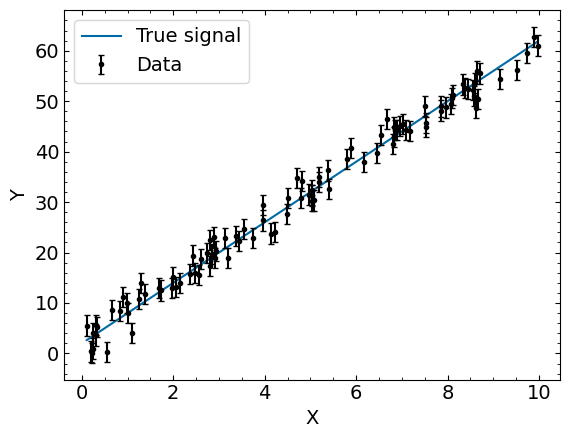

In [4]:
N = 100  # Nombre de points
m_true, b_true = 6, 2
p_true = np.array([m_true, b_true])
noise_level = 2  # Écrat-type du bruit gaussien

x = np.sort(rng.uniform(0, 10, size=N))
y_true = linear_model(p_true, x)

# Bruit gaussien indépendant avec barres d'erreur uniformes
yerr = noise_level * np.ones_like(x)  # `ones_like` crée un tableau rempli de 1, mais avec la même taille que x
y = y_true + yerr * rng.standard_normal(N)

plt.plot(x, y_true, label="True signal")
plt.errorbar(x, y, yerr=yerr, fmt="k.", label="Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

Voilà, on voit que les données sont assez proches du vrai signal, donc il ne devrait pas être trop difficile d'ajuster une droite
et d'arriver à la bonne réponse.

### Ajustement du modèle
Pour l'ajustement du modèle, nous effectuerons une simple minimisation du $\chi^2$ avec `scipy.optimize.minimize`.

Les fonctions données à `minimize` doivent avoir un premier argument `p` qui est un tableau contenant les paramètres du modèle.

In [5]:
def chi2_fun(
    p: np.ndarray[float],
    x: np.ndarray[float],
    y: np.ndarray[float],
    yerr: np.ndarray[float],
) -> float:
    """Chi2 pour un modèle linéaire

    :param p: Paramètres du modèle, m et b
    :param x: Valeurs X des données
    :param y: Valeurs Y des données
    :param yerr: Incertitude en Y sur les données
    :return: $\chi^2$ pour l'ensemble des données
    """
    y_mod = linear_model(p, x)
    return np.sum((y - y_mod)**2 / yerr**2)

En plus de la fonction `chi2_fun`, nous aurons besoin d'un estimé initial des paramètres, $m = 5$ et $b = 6$ semblent fournir une droite plutôt réaliste.

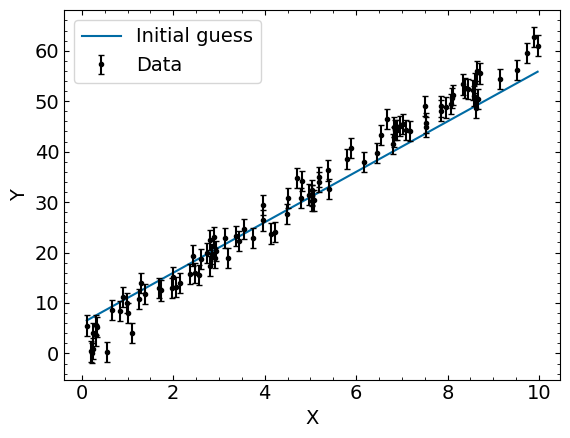

In [6]:
p_guess = np.array([5, 6])

plt.plot(x, linear_model(p_guess, x), label="Initial guess")
plt.errorbar(x, y, yerr=yerr, fmt="k.", label="Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [7]:
opt_res = minimize(chi2_fun, p_guess, args=(x, y, yerr))

In [8]:
opt_res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 104.7836572070009
        x: [ 5.908e+00  2.565e+00]
      nit: 3
      jac: [ 9.537e-07  0.000e+00]
 hess_inv: [[ 2.420e-03 -1.141e-02]
            [-1.141e-02  7.380e-02]]
     nfev: 15
     njev: 5

La minimisation semble avoir bien fonctionné. On peut utiliser le résultat pour comparer le modèle et les données.

In [9]:
p_fit = opt_res.x
best_mod = linear_model(p_fit, x)
res = y - best_mod

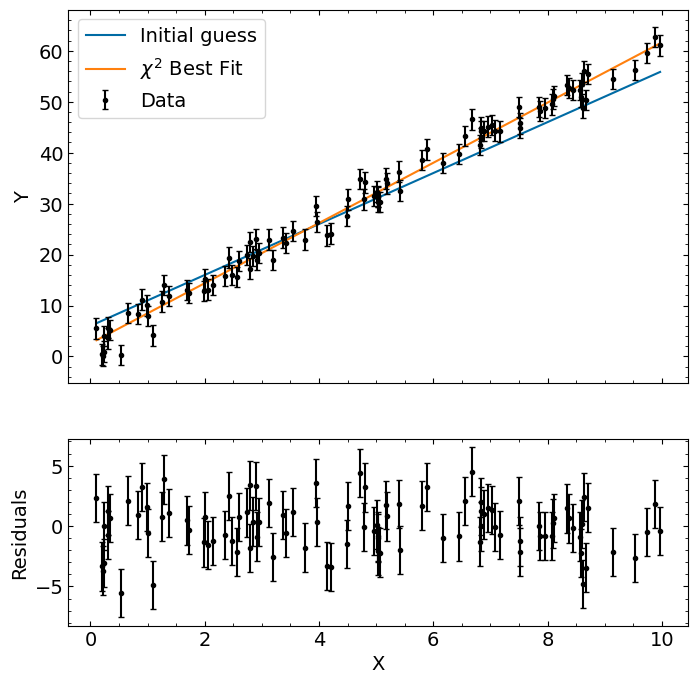

In [10]:
fig, axes = plt.subplots(
    2, 1,
    figsize=(8, 8),
    sharex=True,  # utiliser le même axe des X pour le modèle et les résidus
    gridspec_kw={"height_ratios": (2, 1)}  # Panneau 2x plus haut pour le modèle qu pour les résidus
)
axes[0].plot(x, linear_model(p_guess, x), label="Initial guess")
axes[0].plot(x, best_mod, label="$\chi^2$ Best Fit")
axes[0].errorbar(x, y, yerr=yerr, fmt="k.", label="Data")
axes[0].set_ylabel("Y")
axes[0].legend()

axes[1].errorbar(x, res, yerr=yerr, fmt="k.")
axes[1].set_ylabel("Residuals")

axes[-1].set_xlabel("X")
plt.show()

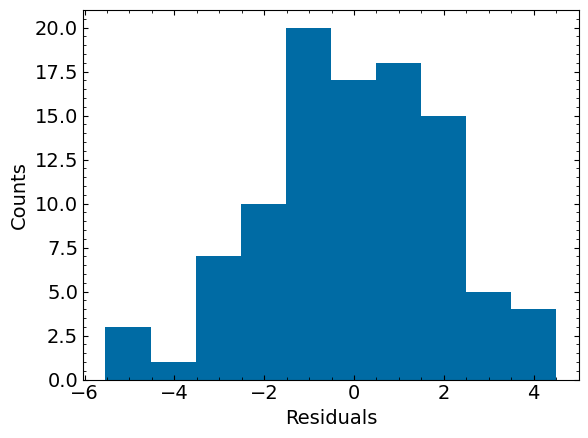

In [11]:
# N'hésitez pas à augmenter N pour avoir un histogramme plus clair
plt.hist(res)
plt.xlabel("Residuals")
plt.ylabel("Counts")
plt.show()

Je vais maintenant sauvegarder le résultat. Le but ici est simplement d'ajouter des fichiers dans le répertoire Git qui devront être ignorés.
Vous pouvez ajouter les deux noms à `.gitignore` pour que Git les ignore et ne tente pas de les publier sur GitHub.

In [12]:
# Save the output
np.savetxt("top_secret_data.txt", np.vstack([x, y, yerr]).T)
np.savetxt("top_secret_model.txt", best_mod)

## Programmation orientée objet

### Types d'objets, méthodes et attributs

La programmation orientée objet permet de définir de nouveaux "types" d'objets.

En Python, tous les objets (variables) que l'on crée ont un type. Par exemple, une chaîne de charactère a un type `str`, et un tableau Numpy a un type `np.ndarray`.

In [13]:
mystr = "allo"
myarr = np.array([1, 2, 3])

In [14]:
type(mystr)

str

In [15]:
type(myarr)

numpy.ndarray

Les types d'objets servent à définir des objets qui partagent des propriétés.

Par exemple, les objets d'un même type partagent les mêmes _méthodes_: les fonction que l'on appelle avec un point après la variable.
Ils ont également les mêmes attributs (par exemple np.ndarray.shape), qui définissent des caractéristiques de l'objet.

In [16]:
# Tous les str ont cette méthode
mystr.upper()

'ALLO'

In [17]:
# La méthode "mean" calcul la moyenne de l'objet "myarr"
myarr.mean()

2.0

In [18]:
# Shape et size sont des attributs de "myarr"
print(myarr.shape)
print(myarr.size)

(3,)
3


### Créer notre propre type d'objet
La programmation orientée objet permet de créer de nouveaux types,
dont nous contrôlons entièrement les caractéristiques.

Ici, supposons que nous avions besoin d'un nouveau type d'objet,
qui permet de stocker des données expérimentales et d'effecteur
certaines opérations.
Nous allons créer une `classe` (un nouveau type d'objet) `Dataset` pour accomplir cette tâche.

**N.B.: Je ne recommande pas d'utiliser cette classe dans votre travail, que ce soit pour la recherche ou pour le cours.
Des _packages_ Python tels que Pandas et Numpy permettent déjà d'entreposer
des données efficacement. Le but ici est seulement de présenter la programmation orientée objet avec un exemple simple.**

In [19]:
class Dataset:
    pass

La classe ci-dessus définit un nouveau type d'objet `Dataset`.
Elle est présentement vide, donc pas mal inutile, mais 
elle néanmoins valide. Elle n'a cependant aucun attribut ou méthode.

In [20]:
useless_data = Dataset()

In [21]:
# `dir` montrera les attributs et méthodes "cachées" (débutant avec `__`) de notre classe.
# Python ajoute ceci à toutes les classes par défault.
dir(useless_data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [22]:
# Dict permet de voir les attributs de notre classe
useless_data.__dict__

{}

Ajoutons maintenant des attributs à notre classe.
On peut définir des attributs x, y et yerr pour entreposer nos données.

La méthode `__init__()` est exécutée à la création d'un objet.
On peut donc s'en servir pour ajouter des attributs.
Le premier argument, `self`, désigne l'objet lui-même.
Il est requis pour toutes les méthodes

In [23]:
class Dataset:
    # __init__() est exécutée à la création d'un objet
    # On doit toujours inclure self comme premier argument
    def __init__(self, x: np.ndarray[float], y: np.ndarray[float], yerr: np.ndarray[float]):
        self.x = np.atleast_1d(x.copy())
        self.y = np.atleast_1d(y.copy())
        self.yerr = np.atleast_1d(yerr.copy())

In [24]:
# Tableaux plus petits pour faciliter la lecture
x_fit = x.copy()
y_fit = y.copy()
yerr_fit = yerr.copy()
x = x_fit[:5]
y = y_fit[:5]
yerr = yerr_fit[:5]
# On doit donner les arguments de __init__() quand on crée notre Dataset
data_with_attributes = Dataset(x, y, yerr)

In [25]:
data_with_attributes.__dict__

{'x': array([0.10575846, 0.19868714, 0.21424111, 0.23929786, 0.24396411]),
 'y': array([5.52954624, 0.39709631, 0.14469275, 3.99709483, 0.97437211]),
 'yerr': array([2., 2., 2., 2., 2.])}

Le Dataset a maintenant des attributs. On peut y accéder et les manipuler

In [26]:
print(data_with_attributes.x)
print(data_with_attributes.x.mean())

[0.10575846 0.19868714 0.21424111 0.23929786 0.24396411]
0.20038973563728324


On peut même remplacer un attribut

In [27]:
data_with_attributes.x = np.array([1, 2, 3, 4, 5])
print(data_with_attributes.x)

[1 2 3 4 5]


Par défaut, `print()` affiche le type et l'adresse dans la mémoire de l'ordinateur... Pas très instructif.

In [28]:
print(data_with_attributes)

Il reste deux problèmes avec notre classe:
1. Elle n'a pas de méthodes pour effectuer des opérations avec les données
2. L'imprimer de donne pas d'information utile

Pour palier au premier problème, on peut ajouter une méthode qui permet de faire une opération quelconque sur les données.
Par exemple, on pourrait ordonner nos données selon les valeurs de X.

Pour les deuxième problème, la méthode `__repr__()` permet de retourner un str qui donnera de l'information sur la classe.

In [29]:
class Dataset:
    def __init__(self, x: np.ndarray[float], y: np.ndarray[float], yerr: np.ndarray[float]):
        self.x = np.atleast_1d(x.copy())
        self.y = np.atleast_1d(y.copy())
        self.yerr = np.atleast_1d(yerr.copy())

    def __repr__(self) -> str:
        return f"Objet Dataset avec:\n  X: {self.x}\n  Y: {self.y}\n  Y error: {self.yerr}\n"

    def sort_data(self) -> None:
        """Ordonner les données selon les valeurs de X"""
        sort_ind = np.argsort(self.x)
        self.yerr= self.yerr[sort_ind]
        self.y = self.y[sort_ind]
        self.x = self.x[sort_ind]

In [30]:
data = Dataset(np.array([8, 5, 4, 9, 3]), y, yerr)

In [31]:
print(data)

Objet Dataset avec:
  X: [8 5 4 9 3]
  Y: [5.52954624 0.39709631 0.14469275 3.99709483 0.97437211]
  Y error: [2. 2. 2. 2. 2.]



Voilà qui est mieux. Si on ordonne les données, l'état interne de notre objet sera modifié. Remarquez la différence entre le `print()` ci-dessus et le prochaine

In [32]:
data.sort_data()

In [33]:
print(data)

Objet Dataset avec:
  X: [3 4 5 8 9]
  Y: [0.97437211 0.14469275 0.39709631 5.52954624 3.99709483]
  Y error: [2. 2. 2. 2. 2.]



Pour n'importe quel objet, on peut manuellement ajouter des attributs. Par contre, il est préférable d'inclure les attributs utiles au moment de la définition.

In [34]:
# Fonctionne, mais préférable de définir l'attribut dans __init__()
data.name = "cooldata"

In [35]:
data.__dict__

{'x': array([3, 4, 5, 8, 9]),
 'y': array([0.97437211, 0.14469275, 0.39709631, 5.52954624, 3.99709483]),
 'yerr': array([2., 2., 2., 2., 2.]),
 'name': 'cooldata'}

### Créer une sous-classe
Une fois qu'une classe existe, on peut créer une "sous-classe", qui héritera des attributs de notre classe.
La sous-classe pourra ensuite avoir des caractéristiques propres à elle-même.

Par exemple, on pourrait normaliser nos données dès la création du `Dataset`

In [36]:
class NormalizedDataset(Dataset):
    def __init__(self, x: np.ndarray[float], y: np.ndarray[float], yerr: np.ndarray[float]):
        # On applique le __init__ du parent ("super")
        super(NormalizedDataset, self).__init__(x, y, yerr)

        # On normalise directement
        # _y_orig permet de conserver les données originales.
        # Le "_" au début dénote un attribut "privé": on ne s'attend pas à ce que l'utilisateur s'en serve directement.
        self._y_orig = self.y.copy()
        self._yerr_orig = self.yerr.copy()

        self.yerr = self.yerr / self.y.mean()
        self.y = self.y / self.y.mean()

In [37]:
norm_data = NormalizedDataset(x, y, yerr)

In [38]:
norm_data

Objet Dataset avec:
  X: [0.10575846 0.19868714 0.21424111 0.23929786 0.24396411]
  Y: [2.50368798 0.1797987  0.06551451 1.80981908 0.44117973]
  Y error: [0.90556724 0.90556724 0.90556724 0.90556724 0.90556724]

C'est tout pour le premier TP!

La première partie devrait avoir été majoritairement de la révision.
Si ce n'est pas le cas, n'hésitez pas à me contacter pour poser des questions ou pour demander des ressources additionnelles.

La programmation orientée objet était possiblement nouvelle pour plusieurs d'entre vous.
On ne l'utilisera pas beaucoup dans le cours, et on en rediscutera plus en détail lorsque nous l'utiliserons.
Par contre, il est bon de savoir que la majorité des "objets" qu'on assigne à une variable en Python sont en fait
créés via une classe avec des attributs et des méthodes!